# Analysing mybinder.org launches

The first few cells download and massage the data. Later on we answer questions on which repositories are popular and such.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import datetime

import pandas as pd

In [2]:
index = pd.read_json("https://archive.analytics.mybinder.org/index.jsonl",
                     lines=True)

In [3]:
# get all days since start of 2019
now = datetime.datetime.now()
n = (now - datetime.datetime(2019, 1, 1)).days

# small range for previewing
n = 10

frames = []
for idx, day in index.sort_index(ascending=False).iterrows():
    df = pd.read_json("https://archive.analytics.mybinder.org/{}".format(day['name']),
                      lines=True, )
    frames.append(df)
    if len(frames) > n:
        break
        
print(f"Fetched data for {n} days.")

Fetched data for 10 days.


In [4]:
df = pd.concat(frames)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [5]:
# make it easier to grab the ref
def get_repo(spec):
    s = spec.rsplit("/", 1)[0]
    if s.endswith('.git'):
        s = s[:-4]
    return s
df['repo'] = df['spec'].apply(get_repo) #lambda s: s.rsplit("/", 1)[0].replace(".git", ""))
df['org'] = df['spec'].apply(lambda s: s.split("/", 1)[0])
df['ref'] = df['spec'].apply(lambda s: s.rsplit("/", 1)[1])

In [6]:
# take a look at the data, does it look sensible?
df.sample(10)

,origin,provider,schema,spec,status,timestamp,version,repo,org,ref
6610,NaN,GitHub,binderhub.jupyter.org/launch,ipython/ipython-in-depth/master,success,2019-06-10 12:53:00,2,ipython/ipython-in-depth,ipython,master
3842,gke.mybinder.org,GitHub,binderhub.jupyter.org/launch,ipython/ipython-in-depth/master,success,2019-06-13 06:29:00,3,ipython/ipython-in-depth,ipython,master
5616,NaN,GitHub,binderhub.jupyter.org/launch,Microsoft/cognitive-services-notebooks/master,success,2019-06-09 19:04:00,2,Microsoft/cognitive-services-notebooks,Microsoft,master
14390,gke.mybinder.org,GitHub,binderhub.jupyter.org/launch,brian-team/brian2-binder/master,success,2019-06-18 22:18:00,3,brian-team/brian2-binder,brian-team,master
15063,gke.mybinder.org,GitHub,binderhub.jupyter.org/launch,DS-100/textbook/master,success,2019-06-13 21:31:00,3,DS-100/textbook,DS-100,master
1062,ovh.mybinder.org,GitHub,binderhub.jupyter.org/launch,ipython/ipython-in-depth/master,success,2019-06-17 03:26:00,3,ipython/ipython-in-depth,ipython,master
4380,ovh.mybinder.org,GitHub,binderhub.jupyter.org/launch,DS-100/textbook/master,success,2019-06-16 16:38:00,3,DS-100/textbook,DS-100,master
7324,gke.mybinder.org,GitHub,binderhub.jupyter.org/launch,ipython/ipython-in-depth/master,success,2019-06-14 13:52:00,3,ipython/ipython-in-depth,ipython,master
8208,NaN,GitHub,binderhub.jupyter.org/launch,jupyterlab/jupyterlab-demo/master,success,2019-06-12 13:13:00,2,jupyterlab/jupyterlab-demo,jupyterlab,master
6781,NaN,GitHub,binderhub.jupyter.org/launch,ipython/ipython-in-depth/master,success,2019-06-12 11:53:00,2,ipython/ipython-in-depth,ipython,master


In [7]:
df = df.drop(columns=['schema', 'version', 'spec', 'status'])

In [8]:
df.head()

,origin,provider,timestamp,repo,org,ref
0,gke.mybinder.org,GitHub,2019-06-19 00:00:00,leecourt98/first-shiny-app-model-asset-exchange,leecourt98,master
1,gke.mybinder.org,GitHub,2019-06-19 00:00:00,ipython/ipython-in-depth,ipython,master
2,gke.mybinder.org,GitHub,2019-06-19 00:00:00,nteract/examples,nteract,master
3,gke.mybinder.org,GitHub,2019-06-19 00:01:00,rdungee/waospy,rdungee,master
4,gke.mybinder.org,GitHub,2019-06-19 00:01:00,noamross/gams-in-r-course,noamross,master


In [9]:
df_ = df.set_index("timestamp")

In [10]:
def n_active_repos(period=30):
    """Unique active repos over the period
    
    With period=30 this gives monthly active repos
    With period=1 you get daily active repos
    """
    now = datetime.datetime.now()
    start = datetime.datetime(2019, 1, 1)
    days_since_start = (now - start).days

    data = []

    for n in range(days_since_start):
        s = start + datetime.timedelta(days=n)
        e = start + datetime.timedelta(days=n+period)
        if e > now:
            break

        # our "monthly" data
        monthly = df_.loc[s.isoformat():e.isoformat()]
        data.append(dict(timestamp=e, repos=len(set(monthly.repo))))
        
    return pd.DataFrame.from_records(data).set_index("timestamp")

In [11]:
monthly_active = n_active_repos(30)
weekly_active = n_active_repos(7)
daily_active = n_active_repos(1)

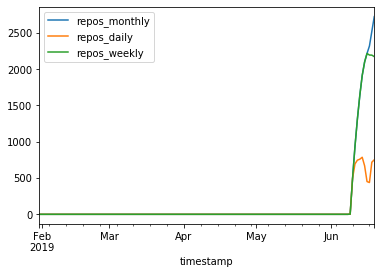

In [12]:
activity = pd.merge(monthly_active, daily_active,
                    suffixes=("_monthly", "_daily"), left_index=True, right_index=True)
activity = pd.merge(activity, weekly_active, left_index=True, right_index=True)

activity.columns = ['repos_monthly', 'repos_daily', 'repos_weekly']
activity.plot();

## Total launches

In [13]:
# Sneak peek: total launches!
df.shape

(132362, 6)

In [14]:
# add a new column showing total launches per repo
totals_per_repo = (df.groupby(["repo"])
 .size()
 .reset_index(name='repo_counts'))

In [15]:
# add a nnew column showing total launches per org
totals_per_org = (df.groupby(["org"])
 .size()
 .reset_index(name='org_counts'))

In [16]:
df_ = pd.merge(df, totals_per_repo, on='repo')
df_ = pd.merge(df_, totals_per_org, on='org')
#df_.sample(10)

## Launches per day

In [17]:
daily = df.set_index("timestamp").resample('D').count()

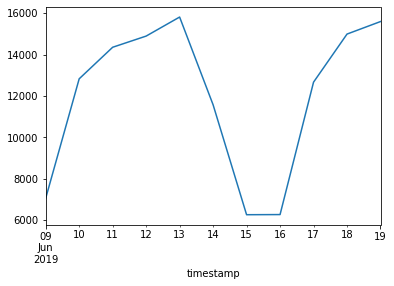

In [18]:
daily['repo'].plot()

## Estimate number of unique repositories

Expect the raw number of launches to be bigger than the number of repositories launched more than once. Those launched only once might have been accidents.

In [19]:
len(set(df.repo))

2851

In [20]:
len(set(df_.repo[df_.repo_counts>1]))

1791

## Where are repositories hosted?

In [21]:
(df.groupby("provider")
   .size()
   .reset_index(name='Launches')
   .sort_values('Launches', ascending=False))

,provider,Launches
2,GitHub,129412
0,Gist,1757
3,GitLab,889
1,Git,261
4,Zenodo,43


## Popular repositories and their branches

Ten most popular repos:

In [22]:
df.groupby("repo").count().sort_values("timestamp", ascending=False).head(20)

,origin,provider,timestamp,org,ref
repo,,,,,
ipython/ipython-in-depth,41188,63893,63893,63893,63893
jupyterlab/jupyterlab-demo,8611,13256,13256,13256,13256
ines/spacy-io-binder,4135,6592,6592,6592,6592
DS-100/textbook,2367,3810,3810,3810,3810
bokeh/bokeh-notebooks,2016,3091,3091,3091,3091
ines/spacy-course,1257,1980,1980,1980,1980
rationalmatter/juno-demo-notebooks,1102,1778,1778,1778,1778
binder-examples/r,1141,1735,1735,1735,1735
binder-examples/requirements,1082,1676,1676,1676,1676


In [23]:
(df_.groupby(["org", "repo", "ref", "repo_counts", "org_counts"])
 .size()
 # give the column a nice name
 .reset_index(name='ref_counts')
 # sort first by total launches, then within a repo by ref launches
 .sort_values(['org_counts', 'repo_counts', 'ref_counts'],
              ascending=[False,False, False])
 .set_index(["org", 'repo', 'ref'])
)

repo_counts  \
org             repo                                        ref                     
ipython         ipython/ipython-in-depth                    master          63893   
                ipython/ipython                             6.x                58   
                                                            master             58   
jupyterlab      jupyterlab/jupyterlab-demo                  master          13256   
                jupyterlab/jupyterlab-latex                 master              5   
                jupyterlab/jupyterlab                       master              3   
                jupyterlab/jupyterlab-data-explorer         master              1   
ines            ines/spacy-io-binder                        live             6592   
                                                            master           6592   
                ines/spacy-course                           binder           1980   
                ines/course-starter-python                  binder             28   
                                                            master             28   
                ines/course-starter-r                       binder             12   
                                                            master             12   
binder-examples binder-examples/r                           master           1735   
                binder-examples/requirements                master           1676   
                                                            fa84f12          1676   
                binder-examples/julia-python                master            802   
                binder-examples/matplotlib-versions         mpl-v2.0          210   
                binder-examples/jupyter-stacks              master            117   
                binder-examples/python2_with_3              master             79   
                binder-examples/conda_environment           v1.0               36   
                binder-examples/jupyterlab                  master             28   
                binder-examples/bokeh                       master             21   
                binder-examples/jupyter-rise                master             17   
                binder-examples/multi-language-demo         master             12   
                binder-examples/appmode                     master             10   
                binder-examples/python-conda_pip            master              9   
                binder-examples/stencila-py                 master              8   
                binder-examples/demo-julia                  master              7   
...                                                                           ...   
vincentherrmann vincentherrmann/time_frequency_analysis     master              1   
vinci1it2000    vinci1it2000/formulas                       master              1   
virtualzx-nad   virtualzx-nad/tutorial-test                 master              1   
vishnuvrg       vishnuvrg/Data-Structures-and-Algorithms    master              1   
voytekresearch  voytekresearch/fooof                        master              1   
vsmolyakov      vsmolyakov/experiments_with_python          master              1   
vstatkevich     vstatkevich/iab_google                      master              1   
vsub21          vsub21/systemic-risk-dashboard              master              1   
wdecoster       wdecoster/NanoPlot                          master              1   
wilfwilson      wilfwilson/semigroups-in-algebraic-research master              1   
williamfgc      williamfgc/notebooks                        master              1   
willimemo       willimemo/willimemo.github.io               master              1   
wmvanvliet      wmvanvliet/SNL_workshop_2019                master              1   
wolfram74       wolfram74/binder_test                       master              1   
wolfv           wolfv/Mathics                               binder         